# Задача 2.4-9: SGD + Nesterov для аппроксимации функции

В этом ноутбуке полином 3-й степени обучается мини-батч SGD с импульсом Нестерова.


## Импорты и стиль графиков


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (11, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11


## Функция, модель и данные


In [16]:
def func(x):
    return -0.7 * x - 0.2 * x**2 + 0.05 * x**3 - 0.2 * np.cos(3 * x) + 2


def df(x):
    return -0.7 - 0.4 * x + 0.15 * x**2 - 0.6 * np.sin(3 * x)


def loss(w, x, y):
    return np.mean((x @ w - y) ** 2)


def compute_gradient_compact(w, x_batch, y_batch):
    n = x_batch.shape[0]
    errors = x_batch @ w - y_batch
    return (2.0 / n) * (errors @ x_batch)


def average_risk(w, x, y):
    return np.mean((x @ w - y) ** 2)


coord_x = np.arange(-4.0, 6.0, 0.1)
coord_y = func(coord_x)

S = np.column_stack([
    np.ones_like(coord_x),
    coord_x,
    coord_x**2,
    coord_x**3,
])


## Гиперпараметры и обучение


In [17]:
# Гиперпараметры
eta = np.array([0.1, 0.01, 0.001, 0.0001])
w = np.array([0.0, 0.0, 0.0, 0.0])
N = 500
lm = 0.02
batch_size = 20
gamma = 0.8
v = np.zeros_like(w)

np.random.seed(0)

# История для графиков
risk_history = []
qe_history = []
w_history = [w.copy()]

Qe = loss(w, S, coord_y)
sz = len(coord_x)

for _ in range(N):
    k = np.random.randint(0, sz - batch_size - 1)
    S_batch = S[k:k + batch_size]
    y_batch = coord_y[k:k + batch_size]

    impulse = w - gamma * v
    grad = compute_gradient_compact(impulse, S_batch, y_batch)

    v = gamma * v + (1 - gamma) * eta * grad
    w = w - v

    batch_loss = loss(w, S_batch, y_batch)
    Qe = lm * batch_loss + (1 - lm) * Qe
    Q = average_risk(w, S, coord_y)

    qe_history.append(Qe)
    risk_history.append(Q)
    w_history.append(w.copy())

print(f'Q = {risk_history[-1]:.6f}, Qe = {qe_history[-1]:.6f}')
print(f'w = {w}')


Q = 0.020238, Qe = 0.020636
w = [ 2.00087266 -0.69417019 -0.1972715   0.04912324]


## Результаты и графики


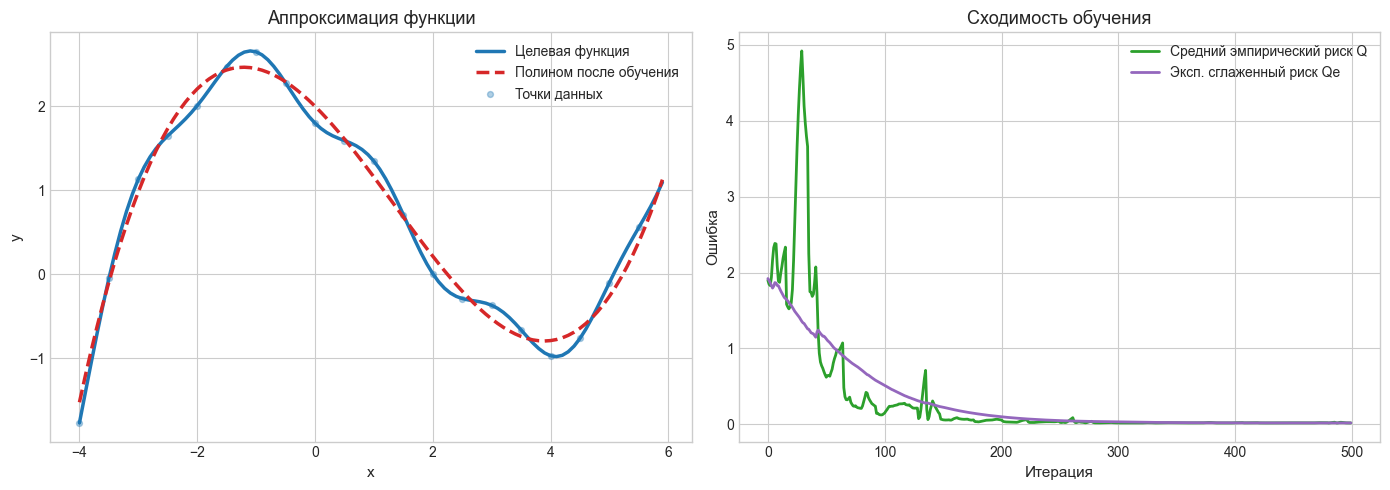

In [18]:
# Прогноз текущей модели
pred_y = S @ w

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: целевая функция и аппроксимация
axes[0].plot(coord_x, coord_y, color='#1f77b4', linewidth=2.5, label='Целевая функция')
axes[0].plot(coord_x, pred_y, color='#d62728', linewidth=2.5, linestyle='--', label='Полином после обучения')
axes[0].scatter(coord_x[::5], coord_y[::5], s=18, alpha=0.35, color='#1f77b4', label='Точки данных')
axes[0].set_title('Аппроксимация функции')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend(loc='best')

# График 2: сходимость ошибки
axes[1].plot(risk_history, color='#2ca02c', linewidth=2, label='Средний эмпирический риск Q')
axes[1].plot(qe_history, color='#9467bd', linewidth=2, label='Эксп. сглаженный риск Qe')
axes[1].set_title('Сходимость обучения')
axes[1].set_xlabel('Итерация')
axes[1].set_ylabel('Ошибка')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()


## Динамика обучения (анимация)


In [19]:
# Анимация: как кривая модели приближается к целевой функции
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(coord_x, coord_y, color='#1f77b4', linewidth=2.2, label='Целевая функция')
fit_line, = ax.plot([], [], color='#d62728', linewidth=2.2, linestyle='--', label='Текущая модель')
text = ax.text(0.02, 0.95, '', transform=ax.transAxes, va='top')

ax.set_title('Динамика аппроксимации (SGD + Nesterov)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='best')

sample_step = 10
frame_ids = list(range(0, len(w_history), sample_step))
if frame_ids[-1] != len(w_history) - 1:
    frame_ids.append(len(w_history) - 1)


def init():
    fit_line.set_data([], [])
    text.set_text('')
    return fit_line, text


def update(frame_idx):
    i = frame_ids[frame_idx]
    w_i = w_history[i]
    pred_i = S @ w_i

    fit_line.set_data(coord_x, pred_i)
    text.set_text(f'Итерация: {i} / {N}')
    return fit_line, text


ani = FuncAnimation(
    fig,
    update,
    frames=len(frame_ids),
    init_func=init,
    interval=120,
    blit=True,
    repeat=False,
)

plt.close(fig)
HTML(ani.to_jshtml())
